# **Klasifikasi Penyakit pada Tomat menggunakan YOLOv8:Nano-size**

# Install dependencies

In [ ]:
!pip install kaggle

In [ ]:
!pip install --upgrade ultralytics==8.0.180

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.0/617.0 kB 4.2 MB/s eta 0:00:00


# Import Libraries

In [ ]:
import os
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import files
from ultralytics import YOLO
from IPython.display import display, Image

# Import Dataset

In [ ]:
#uploading kaggle key

upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#downloading and extracting dataset

if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources

!unzip tomato-disease-multiple-sources

Streaming output truncated to the last 5000 lines.
  inflating: valid/Late_blight/9afc2537-1b13-4c25-b5ed-5b8de511b0ab___GHLB2 Leaf 9033.JPG  
  inflating: valid/Late_blight/9bb49d22-976d-40c3-bc9a-bff5cbbd8e28___RS_Late.B 5057.JPG  
  inflating: valid/Late_blight/9c274db5-2f89-4f3c-b9e2-4d5ebc54ddad___GHLB2 Leaf 9096.JPG  
  inflating: valid/Late_blight/9c726f4e-045b-4080-b53d-d7e66d45bcb1___RS_Late.B 4876.JPG  
  inflating: valid/Late_blight/9e5dd34f-124c-4a64-ba9f-77c8d05faa9c___GHLB2 Leaf 8749.JPG  
  inflating: valid/Late_blight/9e633823-3dde-450c-8172-733021e4dff0___RS_Late.B 6414.JPG  
  inflating: valid/Late_blight/9ecb8001-2f48-4487-b287-535dbcfb5c2f___RS_Late.B 6206.JPG  
  inflating: valid/Late_blight/9f7dcd60-e691-4c1e-830e-7495f7cc123d___RS_Late.B 6166.JPG  
  inflating: valid/Late_blight/Bacterial_spots2276_jpg.rf.5becd3793ec2a532bf8f111d60911c63.jpg  
  inflating: valid/Late_blight/IMG_1526_jpg.rf.5e25005985e2b12a6f52bfa7120f3eee.jpg  
  inflating: valid/Late_blight/IMG_

# Preprocessing

In [ ]:
#making new "test" directory

os.makedirs('/content/test')

In [ ]:
#moving half from valid to test
#distribution of datasets become 8:1:1 (train:valid:test)

src_dir = '/content/valid/'
dest_dir = '/content/test/'

subdirs = [d for d in os.listdir(src_dir)]

for dir in subdirs:
    src_path = os.path.join(src_dir, dir)
    dest_path = os.path.join(dest_dir, dir)

    if not os.path.exists(dest_path):
        os.makedirs(dest_path)

    files = os.listdir(src_path)

    num_files = int(len(files) * 0.5)

    files_to_move = random.sample(files, num_files)

    for file in files_to_move:
        source_file_path = os.path.join(src_path, file)
        destination_file_path = os.path.join(dest_path, file)
        shutil.move(source_file_path, destination_file_path)

In [ ]:
#confirming test-valid-test sizes

folder_dir = ['/content/train/',
              '/content/valid/',
              '/content/test/']

folder_sizes = []
total_files = 0

for folder in folder_dir:
  size = 0
  for file in os.listdir(folder):
    size += len(os.listdir(os.path.join(folder, file)))
  folder_sizes.append(size)
  total_files += size

for i in range(3):
  print(f'{folder_dir[i]} has {(folder_sizes[i]/total_files)*100}% share')

FileNotFoundError: ignored

In [ ]:
#moving folders to dedicated folder

os.rename("/content/valid/", "/content/val/")

folder_dir[1] = "/content/val/"

os.makedirs('/content/tomato-pcd/')

for folder in folder_dir:
  shutil.move(folder, '/content/tomato-pcd/')

In [ ]:
#counting data distribution

train_folder = '/content/tomato-pcd/train'
val_folder = '/content/tomato-pcd/val'
test_folder = '/content/tomato-pcd/test'

def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tif', '.tiff')):
                count += 1
    return count

train_count = count_images_in_folder(train_folder)
val_count = count_images_in_folder(val_folder)
test_count = count_images_in_folder(test_folder)

total_size = train_count + val_count + test_count

train_percentage = (train_count / total_size) * 100
val_percentage = (val_count / total_size) * 100
test_percentage = (test_count / total_size) * 100

print(f'Train count : {train_count}\nVal count : {val_count}\nTest count : {test_count}')

Train count = 25851
Val count = 3344
Test count = 3340


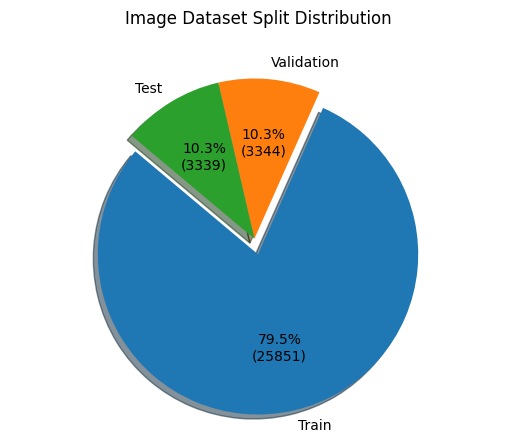

In [ ]:
#data distribution visualization

%matplotlib inline

labels = ['Train', 'Validation', 'Test']
sizes = [train_percentage, val_percentage, test_percentage]
explode = (0.1, 0, 0)

def autopct_format(pct):
    item_count = int((pct / 100) * total_size)
    return f'{pct:.1f}%\n({item_count})'

plt.pie(sizes, explode=explode, labels=labels, autopct=autopct_format, shadow=True, startangle=140)
plt.axis('equal')

plt.title('Image Dataset Split Distribution', y=1.08)
plt.show()

# Split Class Distributions

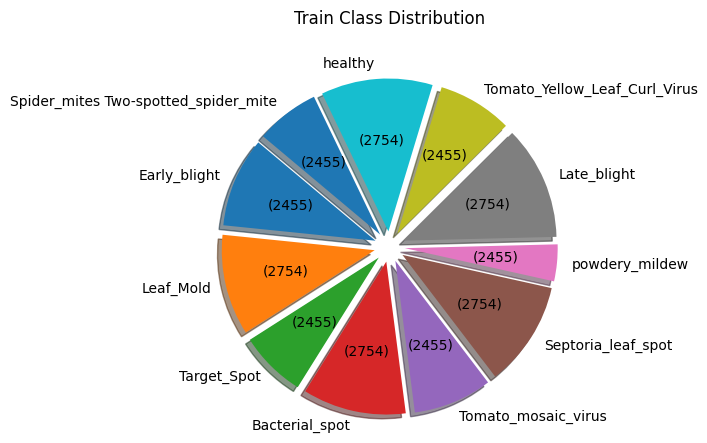

In [ ]:
#train class distribution

def count_images_in_classes(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_count = len(os.listdir(class_path))
            class_counts[class_name] = class_count
    return class_counts

class_counts = count_images_in_classes(train_folder)

labels = class_counts.keys()
sizes = class_counts.values()

explode = [0.1] * len(class_counts)

def autopct_format(pct):
    index = int(pct / 10)
    class_name = list(class_counts.keys())[index]
    return f'({class_counts[class_name]})'

plt.pie(sizes, explode=explode, labels=labels, autopct=autopct_format, shadow=True, startangle=140)
plt.axis('equal')

plt.title('Train Class Distribution', y=1.08)
plt.show()

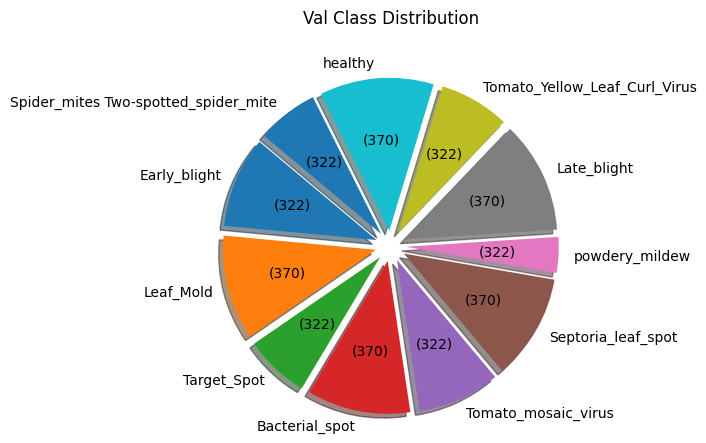

In [ ]:
#val class distribution

class_counts = count_images_in_classes(val_folder)

labels = class_counts.keys()
sizes = class_counts.values()

explode = [0.1] * len(class_counts)

plt.pie(sizes, explode=explode, labels=labels, autopct=autopct_format, shadow=True, startangle=140)
plt.axis('equal')

plt.title('Val Class Distribution', y=1.08)
plt.show()

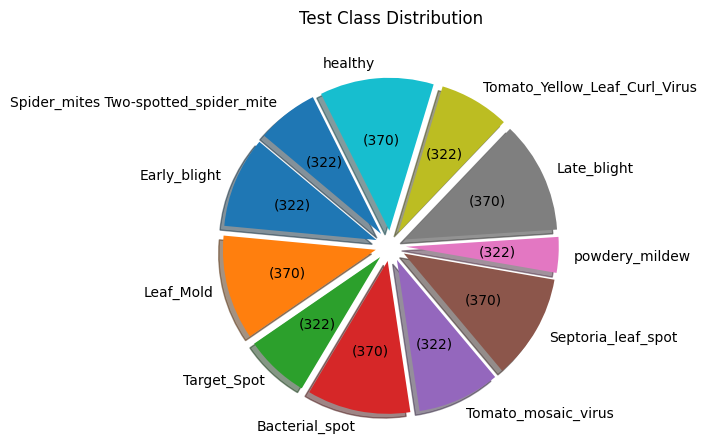

In [ ]:
#test class distribution

class_counts = count_images_in_classes(test_folder)

labels = class_counts.keys()
sizes = class_counts.values()

explode = [0.1] * len(class_counts)

plt.pie(sizes, explode=explode, labels=labels, autopct=autopct_format, shadow=True, startangle=140)
plt.axis('equal')

plt.title('Test Class Distribution', y=1.08)
plt.show()

# Model Training

In [ ]:
#getting model

model = YOLO('yolov8n-cls')

In [ ]:
#viewing model informations

model

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
#training model

results = model.train(data='/content/tomato-pcd',
            epochs = 1,
            task='classify',
            imgsz = 224,
            batch = 8)

New https://pypi.org/project/ultralytics/8.0.199 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/tomato-pcd, epochs=1, patience=50, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic

# Model Evaluation

In [ ]:
#getting best model (on weights)

best_model = YOLO('/content/runs/classify/train3/weights/best.pt')

best_model

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
#getting metrics (on val and test) on best model

metrics_val = best_model.val(data='/content/tomato-pcd', split='val')
metrics_test = best_model.val(data='/content/tomato-pcd', split='test')

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
train: /content/tomato-pcd/train... found 25851 images in 11 classes ✅ 
val: /content/tomato-pcd/val... found 3344 images in 11 classes ✅ 
test: /content/tomato-pcd/test... found 3340 images in 11 classes ✅ 
val: Scanning /content/tomato-pcd/val... 3344 images, 0 corrupt: 100%|██████████| 3344/3344 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 209/209 [00:54<00:00,  3.82it/s]
                   all      0.903      0.996
Speed: 0.0ms preprocess, 12.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val4
Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
train: /content/tomato-pcd/train... found 25851 images in 11 classes ✅ 
val: /content/tomato-pcd/val... found 3344 images in 11 classes ✅ 
test: /content/tomato-pcd/test... found 3340 images in 11 classes ✅ 
test: Scanning /content/tomato-pcd/test... 33

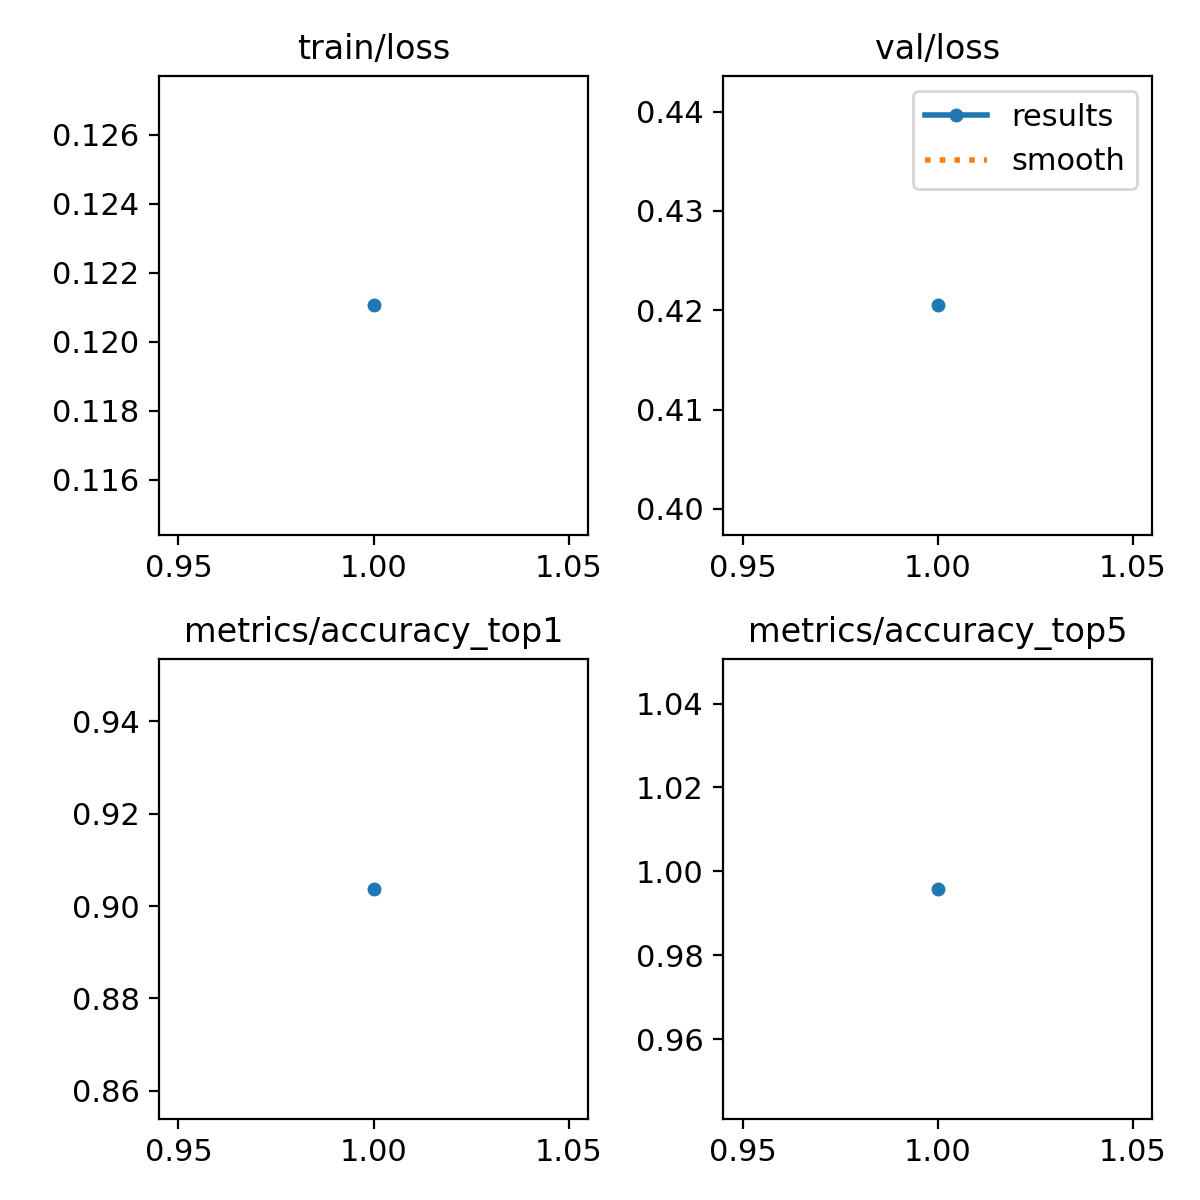

In [ ]:
#view train/val loss

Image(filename='/content/runs/classify/train3/results.png', width=600)

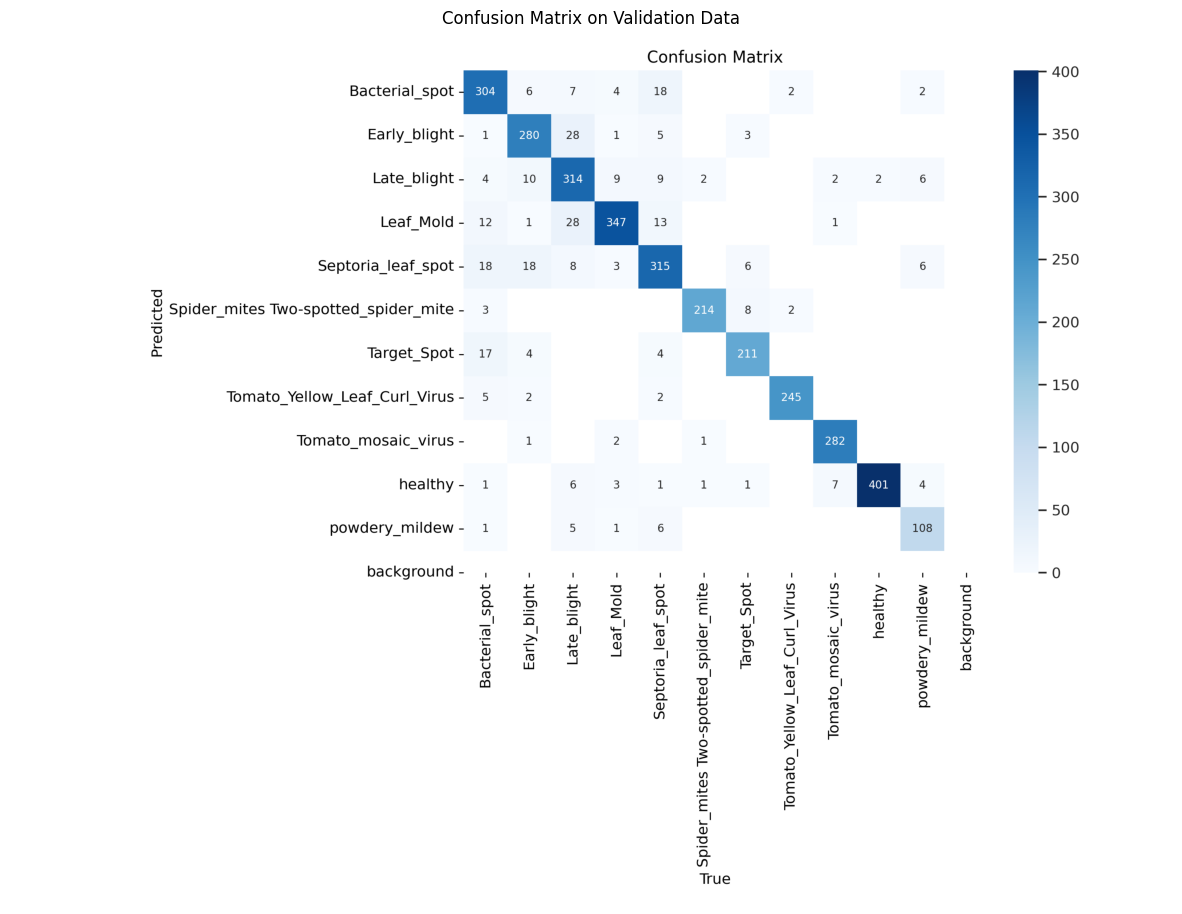

In [ ]:
#val data confusion matrix

%matplotlib inline

img = mpimg.imread('/content/runs/classify/val/confusion_matrix.png')

fig, ax = plt.subplots(figsize = (15, 15))

ax.set_title('Confusion Matrix on Validation Data')
ax.imshow(img)
ax.axis('off');

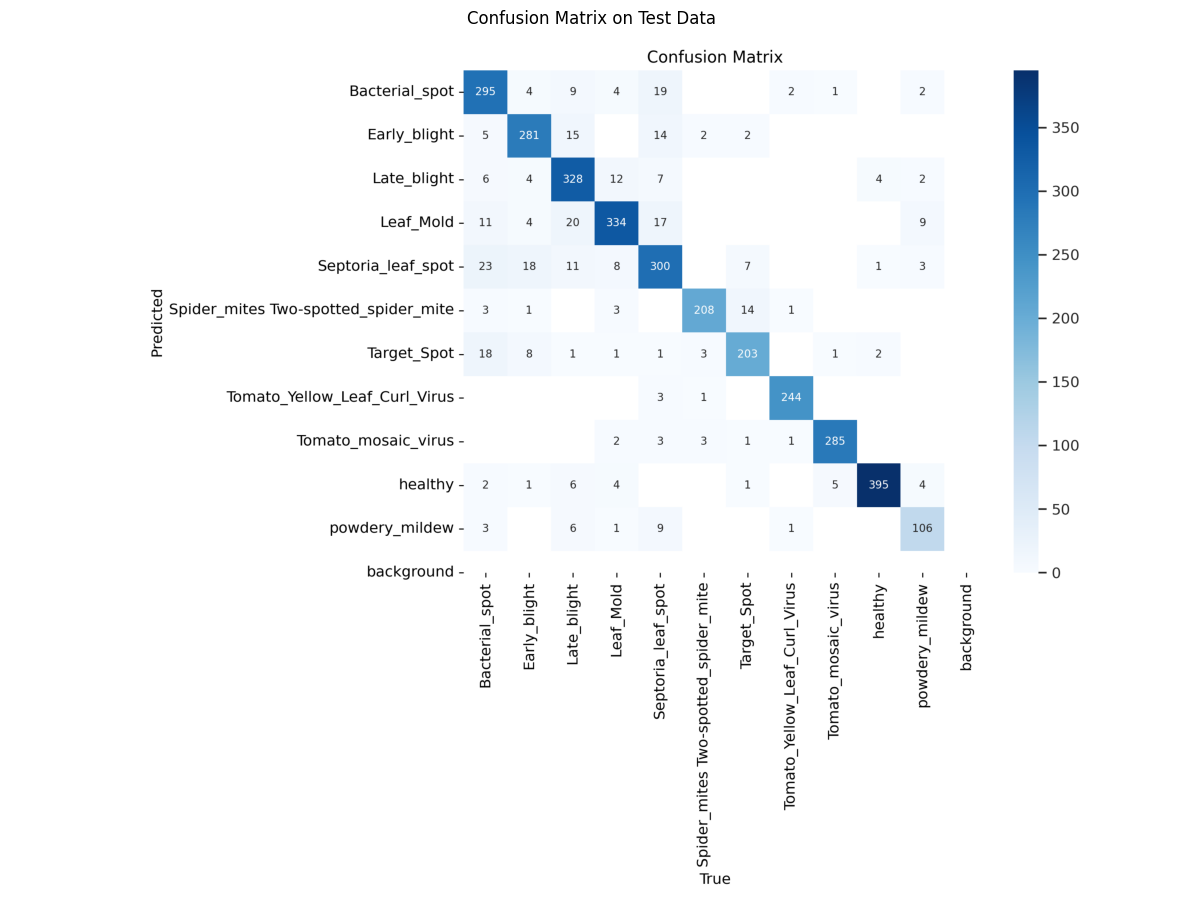

In [ ]:
#test data confusion matrix

%matplotlib inline

img = mpimg.imread('/content/runs/classify/val2/confusion_matrix.png')

fig, ax = plt.subplots(figsize = (15, 15))

ax.set_title('Confusion Matrix on Test Data')
ax.imshow(img)
ax.axis('off');

In [ ]:
#getting confusion matrix as 2d np array

cf_matrix = metrics_test.confusion_matrix.matrix

In [ ]:
#calculating performance metrics for each class

classes = ['Bacterial Spot',
           'Early Blight',
           'Late Blight',
           'Leaf Mold',
           'Leaf Spot',
           'Spider Mites',
           'Target Spot',
           'Curl Virus',
           'Mosaic Virus',
           'Healthy',
           'Powdery Mildew']

TP_arr = []
FP_arr = []
FN_arr = []
precision_arr = []
recall_arr = []
f1_arr = []

rows, cols = cf_matrix.shape

for i in range(rows):
  tp = 0
  fp = 0
  fn = 0
  for j in range(cols):
    if(i==j):
      tp = cf_matrix[i,j]
    else:
      fp += cf_matrix[i, j]
      fn += cf_matrix[j, i]
  TP_arr.append(tp)
  FP_arr.append(fp)
  FN_arr.append(fn)

for i in range(len(TP_arr)):
  precision_arr.append(TP_arr[i] / (TP_arr[i] + FP_arr[i]))
  recall_arr.append(TP_arr[i] / (TP_arr[i] + FN_arr[i]))
  f1_arr.append(2 * (precision_arr[i] * recall_arr[i]) / (precision_arr[i] + recall_arr[i]))

for i in range(len(classes)):
  print(f'{classes[i]}- ')
  print(f'Precision : {precision_arr[i]:.2f}')
  print(f'Recall : {recall_arr[i]:.2f}')
  print(f'F1-Score : {f1_arr[i]:.2f}\n')

Bacterial Spot- 
Precision : 0.88
Recall : 0.81
F1-Score : 0.84

Early Blight- 
Precision : 0.88
Recall : 0.88
F1-Score : 0.88

Late Blight- 
Precision : 0.90
Recall : 0.83
F1-Score : 0.86

Leaf Mold- 
Precision : 0.85
Recall : 0.91
F1-Score : 0.87

Leaf Spot- 
Precision : 0.81
Recall : 0.80
F1-Score : 0.81

Spider Mites- 
Precision : 0.90
Recall : 0.96
F1-Score : 0.93

Target Spot- 
Precision : 0.85
Recall : 0.89
F1-Score : 0.87

Curl Virus- 
Precision : 0.98
Recall : 0.98
F1-Score : 0.98

Mosaic Virus- 
Precision : 0.97
Recall : 0.98
F1-Score : 0.97

Healthy- 
Precision : 0.94
Recall : 0.98
F1-Score : 0.96

Powdery Mildew- 
Precision : 0.84
Recall : 0.84
F1-Score : 0.84



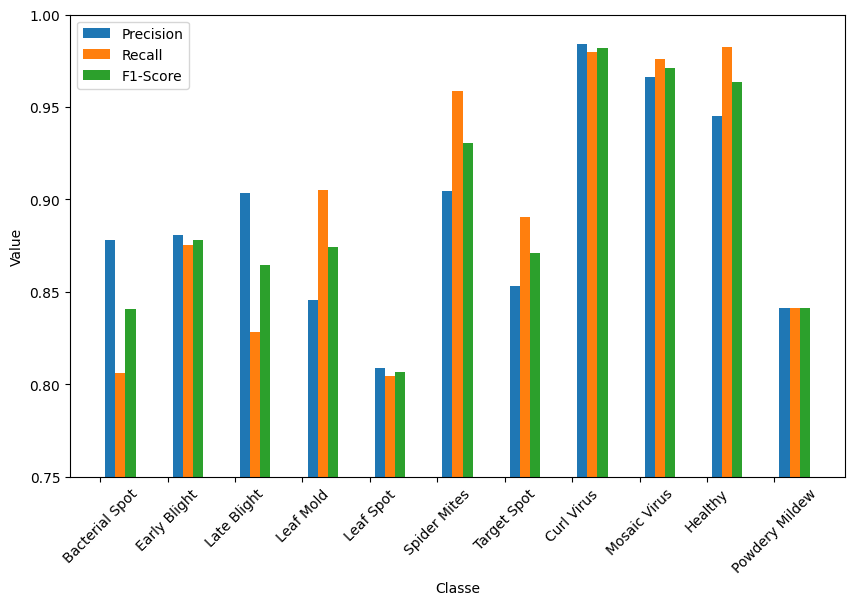

In [ ]:
#displaying performance metrics for each class

%matplotlib inline

n = len(TP_arr)

indices = np.arange(n)

bar_width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))

precision_bars = ax.bar(indices + 3 * bar_width, precision_arr, bar_width, label='Precision')
recall_bars = ax.bar(indices + 4 * bar_width, recall_arr, bar_width, label='Recall')
f1_bars = ax.bar(indices + 5 * bar_width, f1_arr, bar_width, label='F1-Score')

ax.set_xticks(indices + bar_width * 2)
ax.set_xticklabels([f'{i}' for i in classes], rotation=45)

ax.set_ylabel('Value')
ax.set_xlabel('Classe')

ax.set_ylim(0.75, 1.0)

ax.legend()

plt.show()